In [232]:
# Import packages

import numpy as np

import tensorflow as tf

# import wf_psf.SimPSFToolkit as SimPSFToolkit
from wf_psf.sims.psf_simulator import PSFSimulator
import wf_psf.utils as wf_utils
# import wf_psf.tf_psf_field as tf_psf_field
import wf_psf.psf_models.tf_psf_field as tf_psf_field
from wf_psf.psf_models.zernikes import zernike_generator



# Plot style & colormap
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import ImageGrid

# Pre-defined colormap
top = mpl.colormaps['Oranges_r'].resampled(128)
bottom = mpl.colormaps['Blues'].resampled(128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

In [233]:
save_dir = './../plots/'
plot_results = True

repo_dir = "./../../../"

# papers/phase_retrieval_2024/data/paper_output_v1/dataset/train_Euclid_res_2000_TrainStars_id_010_8_bins.npy

star_cat = np.load(
    repo_dir + "papers/phase_retrieval_2024/data/paper_output_v1/dataset/train_Euclid_res_2000_TrainStars_id_010_8_bins.npy",
    allow_pickle=True
)[()]

In [234]:
args = {
    'id_name': '_wf_PR_NewPRoj_12_cycles_v2' ,
    'suffix_id_name': 'v2' ,
    'base_id_name': '_wf_PR_NewPRoj_12_cycles_' ,
    'eval_only_param': False ,
    'total_cycles': 12 ,
    'saved_cycle': 'cycle12' ,
    'reset_dd_features': True ,
    'eval_only_param': False ,
    'project_dd_features': True ,
    'd_max': 2 ,
    'n_zernikes': 45 ,
    'save_all_cycles': True ,
    'n_bins_lda': 8,
    'n_bins_gt': 8,
    'output_dim': 32,
    'batch_size': 32,
    'oversampling_rate': 3.,
    'output_q': 3.,
    'sed_sigma': 0.,
    'x_lims': [0, 1e3],
    'y_lims': [0, 1e3],
    'sed_interp_kind': 'linear',
    'interp_pts_per_bin': 0,
    'extrapolate': True,
    'opt_stars_rel_pix_rmse': True ,
    'eval_mono_metric_rmse': False,
    'eval_opd_metric_rmse': True,
    'eval_train_shape_sr_metric_rmse': True,
    'pupil_diameter': 256 ,
    'n_epochs_param_multi_cycle': "0" ,
    'n_epochs_non_param_multi_cycle': "75" ,
    'l_rate_non_param_multi_cycle': "0.1" ,
    'l_rate_param_multi_cycle': "0" ,
    'l_rate_param': None,
    'l_rate_non_param': None,
    'n_epochs_param': None,
    'n_epochs_non_param': None,
    'model': 'poly' ,
    'model_eval': 'poly' ,
    'cycle_def': 'complete' ,
    'gt_n_zernikes': 45 ,
    'd_max_nonparam': 5 ,
    'saved_model_type': 'external' ,
    'use_sample_weights': True ,
    'l2_param': 0. ,
    'interpolation_type': 'none' ,
    'eval_batch_size': 16 ,
    'train_opt': True ,
    'eval_opt': True ,
    'plot_opt': True ,
    'dataset_folder': '.',
    'test_dataset_file': 'test_Euclid_res_id_010_8_bins.npy',
    'train_dataset_file': 'train_Euclid_res_2000_TrainStars_id_010_8_bins.npy',
    'base_path': '.',
    'metric_base_path': '.',
    'chkp_save_path': '.',
    'plots_folder': 'plots/' ,
    'model_folder': 'chkp/' ,
    'log_folder': 'log-files/' ,
    'optim_hist_folder': 'optim-hist/' ,
    'star_numbers': 1 ,
}

In [235]:
simPSF_np = PSFSimulator(
    # zernikes,
    max_order=args['n_zernikes'],
    pupil_diameter=args['pupil_diameter'],
    output_dim=args['output_dim'],
    oversampling_rate=args['oversampling_rate'],
    output_Q=args['output_q']
)

simPSF_np.gen_random_Z_coeffs(max_order=args['n_zernikes'])
z_coeffs = simPSF_np.normalize_zernikes(simPSF_np.get_z_coeffs(), simPSF_np.max_wfe_rms)
simPSF_np.set_z_coeffs(z_coeffs)
simPSF_np.generate_mono_PSF(lambda_obs=0.7, regen_sample=False)

# Obscurations
obscurations = simPSF_np.generate_euclid_pupil_obscurations(N_pix=args['pupil_diameter'], N_filter=2)
tf_obscurations = tf.convert_to_tensor(obscurations, dtype=tf.complex64)

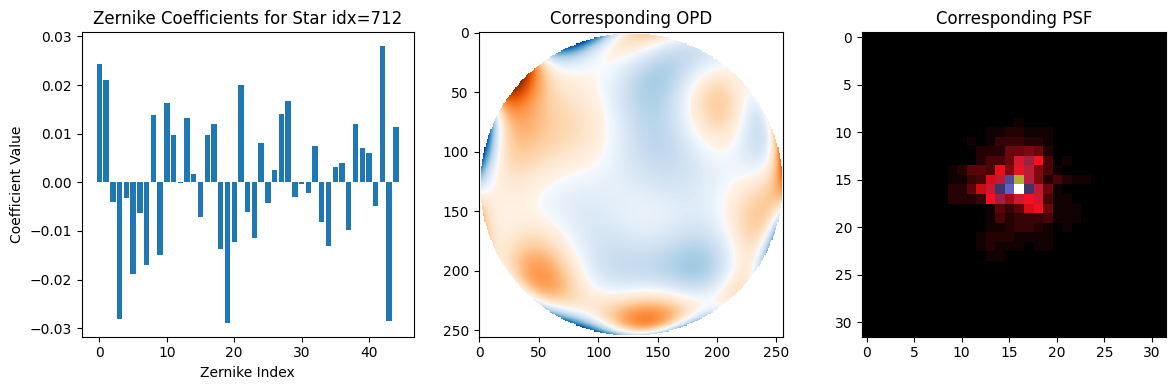

In [236]:
idx = 712
zernike_gt = star_cat['zernike_coef'][idx]
sed_gt = star_cat['SEDs'][idx]
simPSF_np.set_z_coeffs(zernike_gt)
simPSF_np.calculate_opd()
opd_gt = simPSF_np.opd
psf_gt = simPSF_np.generate_poly_PSF(SED=sed_gt)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.bar(range(len(zernike_gt.flatten())), zernike_gt.flatten())
plt.xlabel('Zernike Index')
plt.ylabel('Coefficient Value')
plt.title('Zernike Coefficients for Star idx={}'.format(idx))
plt.subplot(1,3,2)
plt.imshow(opd_gt, cmap=newcmp)
plt.title('Corresponding OPD')
plt.subplot(1,3,3)
plt.imshow(psf_gt, cmap='gist_stern')
plt.title('Corresponding PSF')
plt.tight_layout()
plt.show()


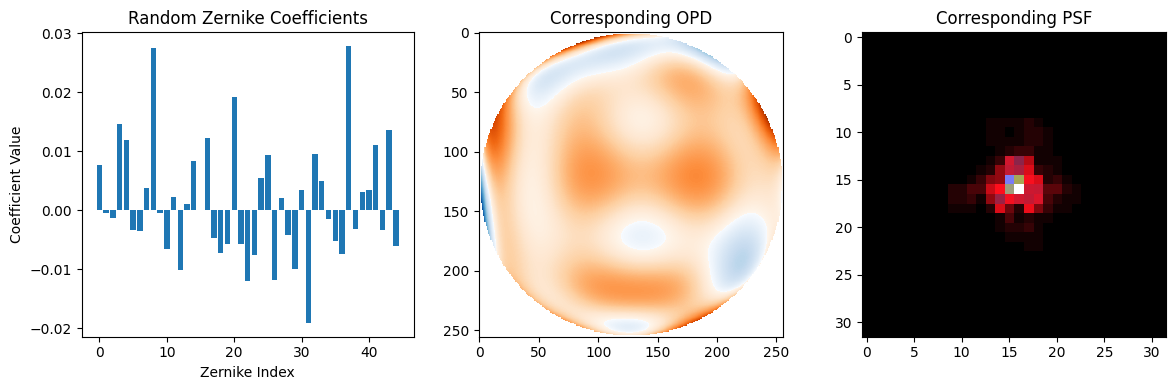

In [237]:
wfe_rms = 1e-2

zk_pred = np.random.randn(45)*wfe_rms
simPSF_np.set_z_coeffs(zk_pred)
simPSF_np.calculate_opd()
opd_pred = simPSF_np.opd

psf_pred = simPSF_np.generate_poly_PSF(SED=sed_gt)

# Plot coefficients and opd
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.bar(range(len(zk_pred.flatten())), zk_pred.flatten())
plt.xlabel('Zernike Index')
plt.ylabel('Coefficient Value')
plt.title('Random Zernike Coefficients')
plt.subplot(1,3,2)
plt.imshow(opd_pred, cmap=newcmp)
plt.title('Corresponding OPD')
plt.subplot(1,3,3)
plt.imshow(psf_pred, cmap='gist_stern')
plt.title('Corresponding PSF')
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Residual, Rel RMSE=33.8 %')

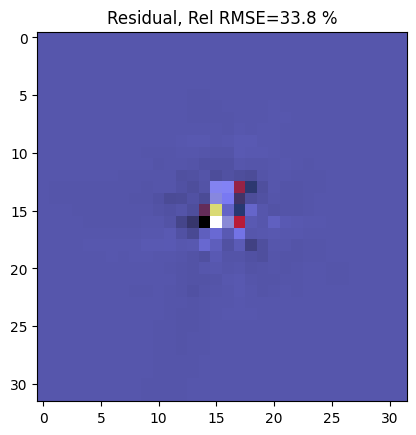

In [238]:
psf_diff = psf_pred - psf_gt
psf_rmse = np.sqrt(np.mean(psf_diff**2))
psf_rmse_rel = psf_rmse / np.sqrt(np.mean(psf_gt**2))

plt.imshow(psf_diff, cmap='gist_stern')
plt.title('Residual, Rel RMSE={:.1f} %'.format(psf_rmse_rel*100))

# Particle Swarm Optimization: WFE recovery

In [254]:
def forward_model(z_coeffs, target_star_idx=77):
    simPSF_np.set_z_coeffs(z_coeffs)
    simPSF_np.calculate_opd()
    psf = simPSF_np.generate_poly_PSF(SED=star_cat['SEDs'][idx])
    return np.array(psf)

def loss_function(psf_gt, psf_pred):
    diff = psf_gt - psf_pred
    rmse = tf.sqrt(tf.reduce_mean(diff**2))
    rmse_rel = rmse / tf.sqrt(tf.reduce_mean(psf_gt**2))
    return rmse_rel

In [291]:
n_particles = 15
n_iterations = 150
stochasticity = 0.2
nz = 45
wfe_rms = 1e-2

# For each particle sample random initial zernike coefficients
x = np.random.randn(n_particles, nz) * wfe_rms
local_best = [xi for xi in x]
y = [forward_model(xi) for xi in x]
loss_current = [loss_function(psf_gt, yi) for yi in y]
loss_global = loss_current[np.argmin(loss_current)]
global_best = x[np.argmin(loss_current)]
loss = [loss_global]
best = []
x_list = [x]

for i in range(n_iterations):
    if i % 10 == 0:
        print(f"Iteration {i}, best loss: {loss_global.numpy():.6f}")
    # Update particles
    local_update = [local_best_i - xi for local_best_i, xi in zip(local_best, x)]
    global_update = [global_best - xi for xi in x]
    x = [0.9*xi + np.random.rand()*2.*local_update_i + np.random.rand()*2.*global_update_i + stochasticity*(loss_global.numpy())*np.random.randn(nz)*wfe_rms for xi, local_update_i, global_update_i in zip(x, local_update, global_update)]
    x_list.append(x)
    
    # Evaluate new positions
    y = [forward_model(xi) for xi in x]
    loss_intermediate = [loss_function(psf_gt, yi) for yi in y]

    # Update local bests
    for j in range(n_particles):
        if loss_intermediate[j] < loss_current[j]:
            local_best[j] = x[j]
            if loss_intermediate[j] < loss_global:
                global_best = x[j]
                loss_global = loss_intermediate[j]
    loss_current = loss_intermediate
    best.append(np.argmin(loss_current))
    loss.append(np.min(loss_current))
    

Iteration 0, best loss: 0.261782
Iteration 10, best loss: 0.157492
Iteration 20, best loss: 0.144264
Iteration 30, best loss: 0.138241
Iteration 40, best loss: 0.133048
Iteration 50, best loss: 0.130056
Iteration 60, best loss: 0.130056
Iteration 70, best loss: 0.128389
Iteration 80, best loss: 0.125576
Iteration 90, best loss: 0.121443
Iteration 100, best loss: 0.114525
Iteration 110, best loss: 0.113929
Iteration 120, best loss: 0.109588
Iteration 130, best loss: 0.106871
Iteration 140, best loss: 0.104352


In [ ]:
# np.save('pso_x_list.npy', np.array(x_list), allow_pickle=True)
# np.save('pso_loss.npy', np.array(loss), allow_pickle=True)
# np.save('pso_best.npy', np.array(global_best), allow_pickle=True)

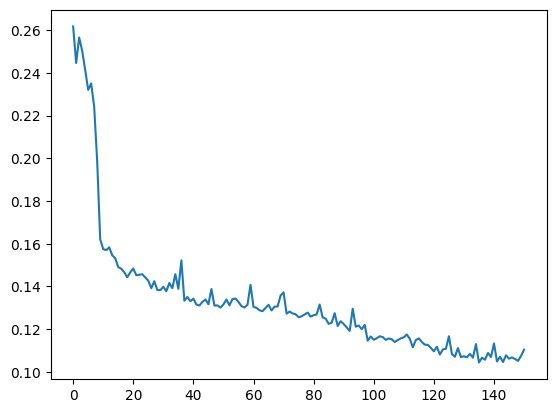

In [292]:
plt.plot(range(n_iterations+1), loss)

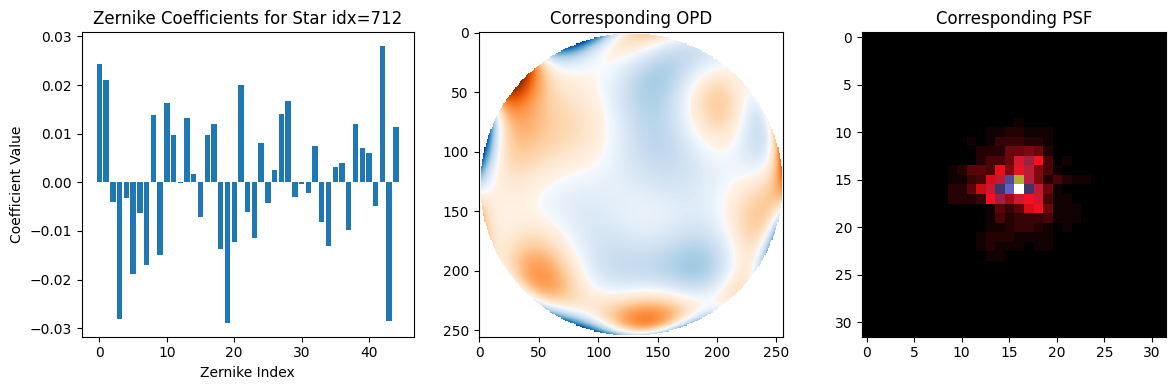

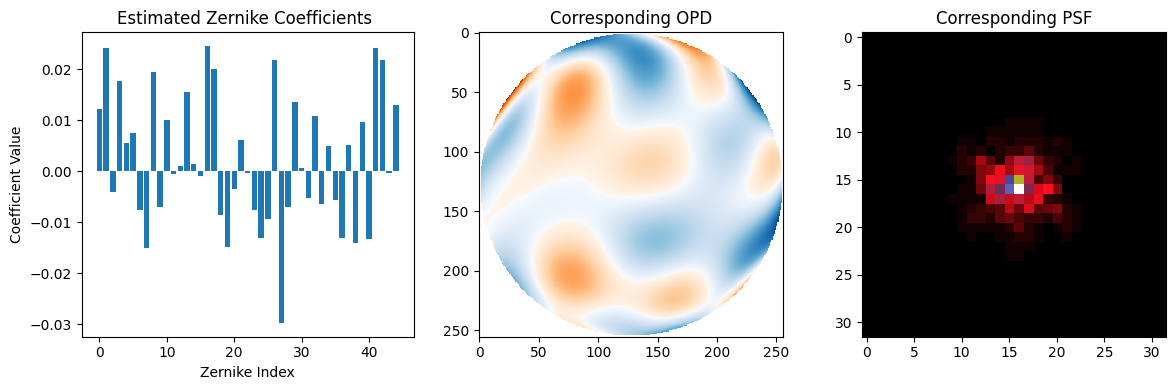

In [299]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.bar(range(len(zernike_gt.flatten())), zernike_gt.flatten())
plt.xlabel('Zernike Index')
plt.ylabel('Coefficient Value')
plt.title('Zernike Coefficients for Star idx={}'.format(idx))
plt.subplot(1,3,2)
plt.imshow(opd_gt, cmap=newcmp)
plt.title('Corresponding OPD')
plt.subplot(1,3,3)
plt.imshow(psf_gt, cmap='gist_stern')
plt.title('Corresponding PSF')
plt.tight_layout()
plt.show()

zk_pred = global_best
simPSF_np.set_z_coeffs(zk_pred)
simPSF_np.calculate_opd()
opd_pred = simPSF_np.opd
psf_pred = simPSF_np.generate_poly_PSF(SED=sed_gt)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.bar(range(len(zk_pred)), zk_pred)
plt.xlabel('Zernike Index')
plt.ylabel('Coefficient Value')
plt.title('Estimated Zernike Coefficients ')
plt.subplot(1,3,2)
plt.imshow(opd_pred, cmap=newcmp)
plt.title('Corresponding OPD')
plt.subplot(1,3,3)
plt.imshow(psf_pred, cmap='gist_stern')
plt.title('Corresponding PSF')
plt.tight_layout()
plt.show()

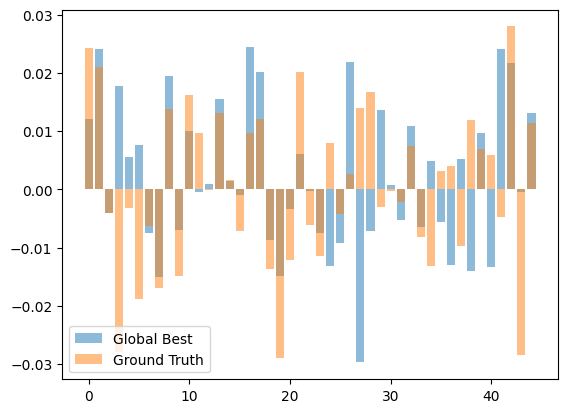

In [300]:
plt.bar(range(nz), global_best, label='Global Best', alpha=0.5)
plt.bar(range(nz), zernike_gt[:,0], label='Ground Truth', alpha=0.5)
plt.legend()

In [322]:
np.sqrt(np.mean((opd_pred[np.where(opd_pred < np.inf)] - opd_gt[np.where(opd_gt < np.inf)])**2)) / np.sqrt(np.mean(opd_gt[np.where(opd_gt < np.inf)]**2)) * 100


115.98947406855977

In [ ]:
# n_particles = 10
# n_iterations = 50
# stochasticity = 0.1
# nz = 45
# w = 0.9
# c1 = 2.
# c2 = 2.

# # For each particle sample random initial zernike coefficients
# x = np.random.randn(n_particles, nz) * wfe_rms
# V = np.zeros((n_particles, nz))
# P = x.copy()
# y = [forward_model(xi) for xi in x]
# loss_current = [loss_function(psf_gt, yi) for yi in y]
# loss_best_personal = loss_current.copy()
# loss_best_global = np.min(loss_current)
# G = x[np.argmin(loss_current)]

# loss_g = [loss_best_global]
# loss_i = [loss_best_global]

# for i in range(n_iterations):
#     V_next = w*V + c1*np.random.rand()*(P - x) + c2*np.random.rand()*(G - x) #+ stochasticity*np.random.randn(nz)*wfe_rms
#     x = x + V_next
#     V = V_next

#     y = [forward_model(xi) for xi in x]
#     loss_intermediate = [loss_function(psf_gt, yi) for yi in y]

#     # Update personal bests
#     for j in range(n_particles):
#         if loss_intermediate[j] < loss_best_personal[j]:
#             P[j] = x[j]
#             loss_best_personal[j] = loss_intermediate[j]
#             if loss_intermediate[j] < loss_best_global:
#                 G = x[j]
#                 loss_best_global = loss_intermediate[j]

#     loss_g.append(loss_best_global)
#     loss_i.append(np.min(loss_intermediate))